In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import itertools

import nltk 
from nltk.corpus import sentiwordnet as swn 

from afinn import Afinn
from plotnine import ggplot, aes, geom_bar, labs, xlim

import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB



# from keras.models import Sequential
# from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping
# from keras.utils import to_categorical



In [2]:
df = pd.read_csv('GTA_V_cleaned.csv')
df.head()

,recommendationid,review,timestamp_created,timestamp_updated,voted_up,votes_up,steamid,playtime_forever,last_played,preprocessed_text
0,134420493,very fun game to play with your friends,1678472945,1678472945,True,0,76561198449880601,28692,2023-03-10 13:27:19,"['fun', 'game', 'friend', 'play']"
1,134420229,"Drive, rob repeat",1678472640,1678472640,True,0,76561199010534593,17734,2023-03-10 11:09:46,"['rob', 'repeat', 'drive']"
2,134415676,It's fun.,1678467049,1678467049,True,0,76561199164783545,12915,2023-02-09 01:42:35,['fun']
3,134413916,"Its GTA 5 ! \nWhats there to say, Its awesome",1678464935,1678464935,True,0,76561198255277604,19630,2023-03-10 13:50:37,"['whats', 'say', 'awesome', 'gta']"
4,134408736,DAMN GAME\n,1678460718,1678460718,True,0,76561199094970526,12964,2023-03-10 11:25:28,"['game', 'damn']"


In [3]:
df_up = df.loc[df['voted_up']==True]

In [4]:
df_up

,recommendationid,review,timestamp_created,timestamp_updated,voted_up,votes_up,steamid,playtime_forever,last_played,preprocessed_text
0,134420493,very fun game to play with your friends,1678472945,1678472945,True,0,76561198449880601,28692,2023-03-10 13:27:19,"['fun', 'game', 'friend', 'play']"
1,134420229,"Drive, rob repeat",1678472640,1678472640,True,0,76561199010534593,17734,2023-03-10 11:09:46,"['rob', 'repeat', 'drive']"
2,134415676,It's fun.,1678467049,1678467049,True,0,76561199164783545,12915,2023-02-09 01:42:35,['fun']
3,134413916,"Its GTA 5 ! \nWhats there to say, Its awesome",1678464935,1678464935,True,0,76561198255277604,19630,2023-03-10 13:50:37,"['whats', 'say', 'awesome', 'gta']"
4,134408736,DAMN GAME\n,1678460718,1678460718,True,0,76561199094970526,12964,2023-03-10 11:25:28,"['game', 'damn']"
...,...,...,...,...,...,...,...,...,...,...
13030,117932451,the most difficult game to play only for proff...,1656600456,1656600456,True,0,76561199095199594,48679,2023-03-10 00:10:12,"['difficult', 'game', 'proffessional', 'player..."
13031,117932281,ewee,1656600278,1656600278,True,0,76561199097752525,34669,2022-07-13 00:04:56,['ewee']
13032,117931745,yes,1656599722,1656599722,True,0,76561199230184990,30760,2023-02-28 19:20:06,['yes']
13033,117931477,hi,1656599439,1656599439,True,0,76561199197433440,49095,2023-03-10 01:19:48,['hi']


In [5]:
afinn = Afinn()
afinn.score('love')



3.0

In [6]:
test = df_up['review'][11]
test_text = ''.join(test)
test_text

'this game is redonkulous!! it just like real life!!!'

In [7]:
score = afinn.score(test_text)
print(score)

2.0


In [8]:
def calculate_sentiment_score(text):
    return afinn.score(text)

In [9]:
df_up['sentiment_score'] = df_up['preprocessed_text'].apply(calculate_sentiment_score)
df_up['sentiment_score'].describe()

/var/folders/18/920vt1r90t39q35zb6glj_6h0000gn/T/ipykernel_8712/4195137041.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


count    11124.000000
mean         1.825153
std          3.270190
min        -51.000000
25%          0.000000
50%          2.000000
75%          3.000000
max         47.000000
Name: sentiment_score, dtype: float64

In [10]:
upper_outl = df_up.loc[df_up['sentiment_score']==47]
print(df.loc[509,'review'])

As a game programmer and level designer with over 2,050 hours on record, and having posted over 300 videos of GTA V on my YouTube channel, I can confidently say that this game is a masterpiece that deserves all the praise it gets.

Graphics: 10/10
The graphics in GTA V are top-notch, with amazing textures, lighting, and special effects that make every pixel pop. As a self-proclaimed graphics nerd, I can appreciate the amount of work that went into creating such a visually stunning game.

Gameplay: 9/10
The gameplay in GTA V is a mix of action, adventure, and sandbox goodness, with an almost infinite array of things to do and places to explore. As a game designer, I can't help but be impressed by the level of creativity and attention to detail that went into crafting such an immersive game.

Storyline: 8/10
The storyline in GTA V is a rollercoaster of drama, comedy, and epicness, with unforgettable characters and plot twists that will leave you wanting more. As a self-proclaimed story n

In [11]:
df_up['sentiment_score'].value_counts()

 0.0     3684
 3.0     2789
 4.0     1042
 1.0      794
 2.0      626
 5.0      305
-3.0      271
-2.0      257
-1.0      241
 6.0      235
 7.0      200
 8.0      123
-4.0      114
 9.0       70
-5.0       54
 10.0      51
 11.0      47
-6.0       32
 13.0      28
 12.0      23
 14.0      21
-7.0       17
 16.0      15
-8.0       11
 15.0      10
-9.0        9
-11.0       7
 19.0       4
 18.0       4
-16.0       4
 17.0       3
-51.0       3
 20.0       3
 29.0       2
-15.0       2
 21.0       2
-12.0       2
 22.0       2
-10.0       2
-13.0       2
 30.0       1
-18.0       1
 39.0       1
 25.0       1
 26.0       1
 31.0       1
-23.0       1
 23.0       1
-44.0       1
 28.0       1
 47.0       1
 40.0       1
-17.0       1
Name: sentiment_score, dtype: int64

/Users/los/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:333: PlotnineWarning: stat_count : Removed 947 rows containing non-finite values.
/Users/los/opt/anaconda3/lib/python3.9/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_bar : Removed 2 rows containing missing values.


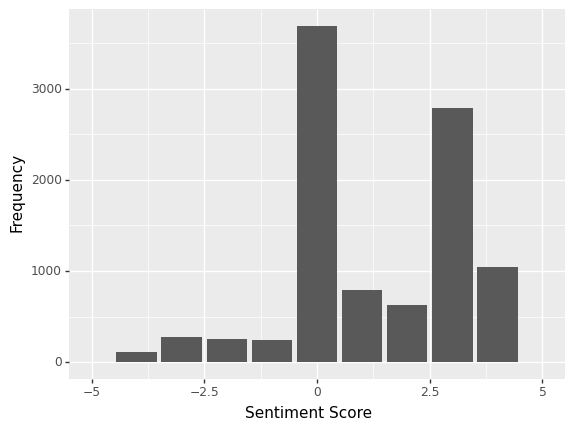

<ggplot: (8769350030388)>

In [12]:
(ggplot(df_up, aes(x='sentiment_score')) 
 + geom_bar() 
 + labs(x="Sentiment Score", y="Frequency") 
 + xlim(-5, 5)
)

### Overall sentiment using AFINN shows that game rarely gets below a nuetral (0) but also has just as many users with positive sentiment as nuetral


In [13]:
nuetral_reviews = df_up[df_up['sentiment_score']==0]
sample_nue_reviews = nuetral_reviews.sample(n=10)
for index, row in sample_nue_reviews.iterrows():
    print(f"Review: {row['review']}")
    print(f"Cleaned Review: {''.join(row['preprocessed_text'])}")
    print(f"Sentiment score: {row['sentiment_score']}\n")


Review: ok
Cleaned Review: ['ok']
Sentiment score: 0.0

Review: game như cc yêu cầu xóa game khỏi steam
Cleaned Review: ['steam', 'yêu', 'như', 'game', 'cc', 'xóa', 'cầu', 'khỏi']
Sentiment score: 0.0

Review: bercumbu dan berpacu
Cleaned Review: ['bercumbu', 'dan', 'berpacu']
Sentiment score: 0.0

Review: Its gta idk how you could down vote this
Cleaned Review: ['idk', 'vote', 'gta', 'could']
Sentiment score: 0.0

Review: 500 hours
Cleaned Review: ['hour']
Sentiment score: 0.0

Review: it toatly lit
Cleaned Review: ['toatly', 'lit']
Sentiment score: 0.0

Review: GOAT
Cleaned Review: ['goat']
Sentiment score: 0.0

Review: Great game to get lost in for a bit.
Cleaned Review: ['lost', 'great', 'game', 'bit', 'get']
Sentiment score: 0.0

Review: dfg
Cleaned Review: ['dfg']
Sentiment score: 0.0

Review: el unico juego donde puedes volar una moto que vuela
Cleaned Review: ['donde', 'juego', 'una', 'que', 'puedes', 'unico', 'volar', 'moto', 'el', 'vuela']
Sentiment score: 0.0



In [14]:
nuetral_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3684 entries, 9 to 13033
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recommendationid   3684 non-null   int64  
 1   review             3684 non-null   object 
 2   timestamp_created  3684 non-null   int64  
 3   timestamp_updated  3684 non-null   int64  
 4   voted_up           3684 non-null   bool   
 5   votes_up           3684 non-null   int64  
 6   steamid            3684 non-null   int64  
 7   playtime_forever   3684 non-null   int64  
 8   last_played        3684 non-null   object 
 9   preprocessed_text  3684 non-null   object 
 10  sentiment_score    3684 non-null   float64
dtypes: bool(1), float64(1), int64(6), object(3)
memory usage: 320.2+ KB


In [15]:
negative_reviews = df_up[df_up['sentiment_score'] < 0]
sample_neg_reviews = negative_reviews.sample(n=10)
for index, row in sample_neg_reviews.iterrows():
    print(f"Review: {row['review']}")
    print(f"Cleaned Review: {''.join(row['preprocessed_text'])}")
    print(f"Sentiment score: {row['sentiment_score']}\n")

Review: i hate this game
Cleaned Review: ['game', 'hate']
Sentiment score: -3.0

Review: very good game if u cheat otherwise its shit
Cleaned Review: ['otherwise', 'u', 'good', 'game', 'shit', 'cheat']
Sentiment score: -4.0

Review: i have a lot of games but most of them i played for couple of hours then i  stop playing them forever. but gta v i keep comming back to!
Cleaned Review: ['game', 'forever', 'gta', 'lot', 'comming', 'keep', 'stop', 'hour', 'playing', 'couple', 'v', 'played', 'back']
Sentiment score: -1.0

Review: Extremely buggy, with frequent CTD's online, regardless of PC performance or file integrity.

Still a blast to play, but a little frustrating

Cleaned Review: ['performance', 'blast', 'pc', 'frustrating', 'play', 'file', 'extremely', 'ctds', 'regardless', 'frequent', 'integritystill', 'little', 'online', 'buggy']
Sentiment score: -2.0

Review: this game is very addictive. I can't stop playing
Cleaned Review: ['addictive', 'game', 'cant', 'stop', 'playing']
Sentiment

In [16]:
negative_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1032 entries, 1 to 13030
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recommendationid   1032 non-null   int64  
 1   review             1032 non-null   object 
 2   timestamp_created  1032 non-null   int64  
 3   timestamp_updated  1032 non-null   int64  
 4   voted_up           1032 non-null   bool   
 5   votes_up           1032 non-null   int64  
 6   steamid            1032 non-null   int64  
 7   playtime_forever   1032 non-null   int64  
 8   last_played        1032 non-null   object 
 9   preprocessed_text  1032 non-null   object 
 10  sentiment_score    1032 non-null   float64
dtypes: bool(1), float64(1), int64(6), object(3)
memory usage: 89.7+ KB


In [17]:
positive_reviews = df_up[df_up['sentiment_score']>0]
sample_pos_reviews = positive_reviews.sample(n=10)
for index, row in sample_pos_reviews.iterrows():
    print(f"Review: {row['review']}")
    print(f"Cleaned Review: {''.join(row['preprocessed_text'])}")
    print(f"Sentiment score: {row['sentiment_score']}\n")

Review: its great
Cleaned Review: ['great']
Sentiment score: 3.0

Review: Very important for single people.......
Cleaned Review: ['people', 'single', 'important']
Sentiment score: 2.0

Review: Good game, even my kids will get to play it before GTA 6 release...
Cleaned Review: ['even', 'gta', 'good', 'game', 'release', 'kid', 'get', 'play']
Sentiment score: 3.0

Review: very good
Cleaned Review: ['good']
Sentiment score: 3.0

Review: its more fun when its modded
Cleaned Review: ['fun', 'modded']
Sentiment score: 4.0

Review: Very cool game but it's plagued by basic problems like anti cheat, and connectivity issues which send this game back 5 years
I completed GTA III, Vice City, Liberty City Stories, SA and V 100% and I love these games, I also finished all the GTA Online's heists and main missions but I wouldn't search for all the collectibles as it's very tedious.

There's a pattern of dull missions in GTA Online and it's saddening. It's such a great game with a questionable executio

In [18]:
positive_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6408 entries, 0 to 13034
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recommendationid   6408 non-null   int64  
 1   review             6408 non-null   object 
 2   timestamp_created  6408 non-null   int64  
 3   timestamp_updated  6408 non-null   int64  
 4   voted_up           6408 non-null   bool   
 5   votes_up           6408 non-null   int64  
 6   steamid            6408 non-null   int64  
 7   playtime_forever   6408 non-null   int64  
 8   last_played        6408 non-null   object 
 9   preprocessed_text  6408 non-null   object 
 10  sentiment_score    6408 non-null   float64
dtypes: bool(1), float64(1), int64(6), object(3)
memory usage: 556.9+ KB


### SentiWordNet

In [19]:
swn_words = [word[0] for row in df_up['preprocessed_text'] for word in row]
synsets = swn.senti_synsets('good', 'a')  # 'a' indicates that the word is an adjective
pos_score = neg_score = obj_score = 0

In [20]:
for syn in synsets:
    pos_score += syn.pos_score()
    neg_score += syn.neg_score()
    obj_score += syn.obj_score()

if len(list(synsets)) >0:
    pos_score /= len(synsets)
    neg_score /= len(synsets)
    obj_score /= len(synsets)
print(f"Positive score: {pos_score:.2f}, Negative score: {neg_score:.2f}, Objective score: {obj_score:.2f}") #Retirating what previously seen, overall postive from all collected

Positive score: 13.00, Negative score: 0.12, Objective score: 7.88


In [21]:
preprocessed_docs = gensim.models.phrases.Phrases(df_up["preprocessed_text"], min_count = 2, threshold = 7)
texts = [eval(text) for text in df_up['preprocessed_text']]
dictionary = gensim.corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
coherence_dict = gensim.corpora.Dictionary(texts)
num_topics = 4

In [22]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            random_state=42,
                                            passes=20,
                                            per_word_topics=True)

In [23]:
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic: {idx}')
    keywords = " ".join(word for word, _ in lda_model.show_topic(idx, topn=5))
    print(f'Top Keywords: {keywords}\n')


Topic: 0
Top Keywords: money computer get life could

Topic: 1
Top Keywords: game good best nice love

Topic: 2
Top Keywords: game fun online play gta

Topic: 3
Top Keywords: cool gta w auto grand



In [24]:
def tokenize(text):
    return [token for token in simple_preprocess(text)]
df_up['review_tokens'] = df_up['review'].apply(tokenize)


/var/folders/18/920vt1r90t39q35zb6glj_6h0000gn/T/ipykernel_8712/2051525475.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
coherence_model = CoherenceModel(
    model=lda_model,
    texts=df_up['review_tokens'].tolist(),
    dictionary=dictionary,
    coherence='u_mass'
)

coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")

Coherence Score: -6.2811483839366264


In [26]:
#Train/Test Split target being sentiment score
X_train, X_test, y_train, y_test = train_test_split(df_up['preprocessed_text'], df_up['sentiment_score'], test_size=0.2, random_state=42)


In [27]:
#Vectorize the text data using the bag-of-words representation
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [28]:
X_train_vect.shape

(8899, 9441)

## Logistic Regression

In [29]:
lr = LogisticRegression()
lr.fit(X_train_vect, y_train)

/Users/los/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [30]:
y_pred = lr.predict(X_test_vect)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1 score:', f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.7204494382022472
Precision: 0.6648764766171514
Recall: 0.7204494382022472
F1 score: 0.6858011355492228


/Users/los/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## Support Vector Machines (SVM)

In [31]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vectorized = vectorizer.fit_transform(X_train)


In [32]:
svc = SVC(kernel='linear')
svc.fit(X_train_vectorized, y_train)

SVC(kernel='linear')

In [33]:
X_test_vectorized = vectorizer.transform(X_test)
y_pred_2 = svc.predict(X_test_vectorized)

In [34]:
print('SVC Accuracy:', accuracy_score(y_test, y_pred_2))
print('SVC Precision:', precision_score(y_test, y_pred_2, average='weighted'))
print('SVM Recall:', recall_score(y_test, y_pred_2, average='weighted'))
print('SVC F1 score:', f1_score(y_test, y_pred_2, average='weighted'))

SVC Accuracy: 0.7635955056179775
SVC Precision: 0.7190943817514583
SVM Recall: 0.7635955056179775
SVC F1 score: 0.7298185464834147


/Users/los/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [35]:
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('svm', SVC(kernel='linear'))
])

parameters = {
    'svm__C': [1, 10],
    'svm__kernel': ['linear', 'rbf']
}

In [36]:
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/los/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(max_features=10000)),
                                       ('svm', SVC(kernel='linear'))]),
             n_jobs=-1,
             param_grid={'svm__C': [1, 10], 'svm__kernel': ['linear', 'rbf']},
             verbose=1)

In [37]:
print("Best parameters: ", grid_search.best_params_)
print("Accuracy: ", grid_search.best_score_)

Best parameters:  {'svm__C': 10, 'svm__kernel': 'linear'}
Accuracy:  0.7459258768023951


In [38]:
grid_svm_best = grid_search.best_estimator_

In [39]:
grid_svc_pred = grid_svm_best.predict(X_test)

In [40]:
print('SVC Accuracy:', accuracy_score(y_test, grid_svc_pred))
print('SVC Precision:', precision_score(y_test, grid_svc_pred, average='weighted'))
print('SVM Recall:', recall_score(y_test, grid_svc_pred, average='weighted'))
print('SVC F1 score:', f1_score(y_test, grid_svc_pred, average='weighted'))

SVC Accuracy: 0.7653932584269663
SVC Precision: 0.7358732786439974
SVM Recall: 0.7653932584269663
SVC F1 score: 0.7481478860054194


/Users/los/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## Random Forest Classifier 

In [41]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_vectorized, y_train)

RandomForestClassifier(random_state=42)

In [42]:
y_pred_3 = rf.predict(X_test_vect)

In [43]:
print('RandomForest Accuracy:', accuracy_score(y_test, y_pred_3))
print('RandomForest Precision:', precision_score(y_test, y_pred_3, average='weighted'))
print('RandomForest Recall:', recall_score(y_test, y_pred_3, average='weighted'))
print('RandomForest F1 score:', f1_score(y_test, y_pred_3, average='weighted'))

RandomForest Accuracy: 0.736629213483146
RandomForest Precision: 0.6971798685940866
RandomForest Recall: 0.736629213483146
RandomForest F1 score: 0.6914333580856931


/Users/los/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [44]:
pipeline_2 = Pipeline([
    ('vectorizer', vectorizer),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

rf_parameters = {'rf__criterion': ['gini', 'entropy'], 
               'rf__max_depth':[30,35,40,45],
               'rf__n_estimators':[5,10,15,20,25]
             
             }

In [45]:
grid_search_2= GridSearchCV(pipeline_2, rf_parameters, cv=5, n_jobs=-1, verbose=1)
grid_search_2.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/Users/los/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(max_features=10000)),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [30, 35, 40, 45],
                         'rf__n_estimators': [5, 10, 15, 20, 25]},
             verbose=1)

In [46]:
print("Best parameters: ", grid_search_2.best_params_)
print("Accuracy: ", grid_search_2.best_score_)

Best parameters:  {'rf__criterion': 'entropy', 'rf__max_depth': 45, 'rf__n_estimators': 20}
Accuracy:  0.6505230813927784


In [47]:
grid_rf_best = grid_search_2.best_estimator_
grid_rf_pred = grid_rf_best.predict(X_test)

In [48]:
print('GridRandomForest Accuracy:', accuracy_score(y_test, grid_rf_pred))
print('GridRandomForest Precision:', precision_score(y_test, grid_rf_pred, average='weighted'))
print('GridRandomForest Recall:', recall_score(y_test, grid_rf_pred, average='weighted'))
print('GridRandomForest F1 score:', f1_score(y_test, grid_rf_pred, average='weighted'))

GridRandomForest Accuracy: 0.6382022471910113
GridRandomForest Precision: 0.6001096809973723
GridRandomForest Recall: 0.6382022471910113
GridRandomForest F1 score: 0.5747765389327142


/Users/los/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## Bernoulli Naive Bayes

In [56]:
nb = GaussianNB()
nb.fit(X_train_vectorized.toarray(),y_train)

GaussianNB()

In [57]:
nb_pred = nb.predict(X_test_vectorized.toarray())

In [59]:
print('NaiveBayes Accuracy:', accuracy_score(y_test, nb_pred))
print('NaiveBayes Precision:', precision_score(y_test, nb_pred, average='weighted'))
print('NaiveBayes Recall:', recall_score(y_test, nb_pred, average='weighted'))
print('NaiveBayes F1 score:', f1_score(y_test, nb_pred, average='weighted'))

NaiveBayes Accuracy: 0.07415730337078652
NaiveBayes Precision: 0.23685503463517255
NaiveBayes Recall: 0.07415730337078652
NaiveBayes F1 score: 0.10554397020352854


/Users/los/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/los/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [63]:
pipeline_nb = Pipeline([('vectorizer',vectorizer),
                        ('nb', GaussianNB())])

nb_parameters = {'nb__var_smoothing': [2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09]}